# TabNet

In [62]:
import os
from datetime import datetime
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchsummary as summary
import pandas as pd
from pytorch_tabnet.tab_model import TabNetClassifier
from pytorch_tabnet.pretraining import TabNetPretrainer
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, auc
from matplotlib import pyplot as plt
import japanize_matplotlib
import seaborn as sns
import mlflow
import mlflow.pytorch

In [2]:
import preprocess_for_all_models as my_preprocess
import word2vec_for_categorical_col as my_word2vec
import preprocess_for_nn as my_nn_preprocess

## 各種定数

In [3]:
RANDOM_STATE = 42
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 64
NUM_EPOCHS = 100
LEARNING_RATE = 0.001
TARGET_COLUMN = "ProdTaken"
DROP_COLUMNS = ["id", "MonthlyIncome", "customer_info"]

In [4]:
# 今日の日付を取得し、YYYYMMDD形式にフォーマットする
today_str: str = datetime.now().strftime("%Y%m%d")

# 今日の日付をディレクトリ名として設定
data_directory_name: str = "../data/" + today_str
model_directory_name: str = "../models/" + today_str

# ディレクトリが存在しない場合、作成する
if not os.path.exists(data_directory_name):
    os.makedirs(data_directory_name)
if not os.path.exists(model_directory_name):
    os.makedirs(model_directory_name)


## 前処理

In [5]:
# ローカルファイルを読み込む
train_df = pd.read_csv("../data/train.csv")
test_df = pd.read_csv("../data/test.csv")
# google colaboratory で実行する場合は以下を有効にする
# from google.colab import drive
# drive.mount('/content/drive')
# train_df = pd.read_csv("/content/drive/mydrive/signate_cup_2024_data/train.csv")
# test_df = pd.read_csv("/content/drive/mydrive/signate_cup_2024_data/test.csv")

In [6]:
# すべてのモデルに共通する前処理を実施
train_df, test_df = my_preprocess.preprocess_total(train_df, test_df)

In [7]:
train_df, test_df = my_nn_preprocess.preprocess_data(train_df, test_df)

"['customer_info_concat'] not found in axis"


## 学習用データの設定

In [8]:
X_train = train_df.drop(columns=[TARGET_COLUMN, "id"]).values  # 入力データ
y_train = train_df[TARGET_COLUMN].values  # ターゲット変数

In [9]:
# 検証用データの作成
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=RANDOM_STATE)

In [25]:
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((2791, 23), (698, 23), (2791,), (698,))

## 事前学習

In [10]:
unsupervised_model = TabNetPretrainer(
    optimizer_fn=optim.AdamW,
    optimizer_params=dict(lr=LEARNING_RATE),
    device_name=DEVICE,
    mask_type="entmax",
)
unsupervised_model.fit(
    X_train,
    eval_set=[X_val],
    batch_size=BATCH_SIZE,
    pretraining_ratio=0.8,
)

/Users/takako/Desktop/GitHub/signate_cup_2024/.venv/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 52.70321| val_0_unsup_loss_numpy: 5.806270122528076|  0:00:00s
epoch 1  | loss: 30.36718| val_0_unsup_loss_numpy: 7.40818977355957|  0:00:01s
epoch 2  | loss: 23.04346| val_0_unsup_loss_numpy: 8.389399528503418|  0:00:02s
epoch 3  | loss: 16.16974| val_0_unsup_loss_numpy: 9.339030265808105|  0:00:02s
epoch 4  | loss: 12.38733| val_0_unsup_loss_numpy: 13.002019882202148|  0:00:03s
epoch 5  | loss: 8.78985 | val_0_unsup_loss_numpy: 13.41748046875|  0:00:04s
epoch 6  | loss: 6.51449 | val_0_unsup_loss_numpy: 10.21448040008545|  0:00:05s
epoch 7  | loss: 5.15442 | val_0_unsup_loss_numpy: 10.526260375976562|  0:00:05s
epoch 8  | loss: 3.93568 | val_0_unsup_loss_numpy: 8.645090103149414|  0:00:06s
epoch 9  | loss: 3.11917 | val_0_unsup_loss_numpy: 7.757229804992676|  0:00:06s
epoch 10 | loss: 2.32742 | val_0_unsup_loss_numpy: 5.454629898071289|  0:00:07s
epoch 11 | loss: 1.91669 | val_0_unsup_loss_numpy: 4.436709880828857|  0:00:08s
epoch 12 | loss: 1.56815 | val_0_unsup_los

/Users/takako/Desktop/GitHub/signate_cup_2024/.venv/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


In [20]:
print(unsupervised_model)

TabNetPretrainer(n_d=8, n_a=8, n_steps=3, gamma=1.3, cat_idxs=[], cat_dims=[], cat_emb_dim=[], n_independent=2, n_shared=2, epsilon=1e-15, momentum=0.02, lambda_sparse=0.001, seed=0, clip_value=1, verbose=1, optimizer_fn=<class 'torch.optim.adamw.AdamW'>, optimizer_params={'lr': 0.001}, scheduler_fn=None, scheduler_params={}, mask_type='entmax', input_dim=23, output_dim=None, device_name=device(type='cpu'), n_shared_decoder=1, n_indep_decoder=1, grouped_features=[])


In [35]:
tabnet_model = TabNetClassifier(
    optimizer_fn=optim.AdamW,
    optimizer_params=dict(lr=LEARNING_RATE),
    device_name=DEVICE,
    verbose=1,
    seed=RANDOM_STATE,
)

/Users/takako/Desktop/GitHub/signate_cup_2024/.venv/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


In [38]:
tabnet_model.fit(
    X_train=X_train,
    y_train=y_train,
    eval_set=[(X_train, y_train), (X_val, y_val)],
    eval_name=["train", "valid"],
    eval_metric=["auc", "auc"],
    max_epochs=NUM_EPOCHS,
    patience=10,
    batch_size=BATCH_SIZE,
    virtual_batch_size=BATCH_SIZE,
    from_unsupervised=unsupervised_model,
)

/Users/takako/Desktop/GitHub/signate_cup_2024/.venv/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:118: UserWarning: Pretraining: mask_type changed from sparsemax to entmax
  warnings.warn(wrn_msg)
/Users/takako/Desktop/GitHub/signate_cup_2024/.venv/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:248: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")


epoch 0  | loss: 0.8442  | train_auc: 0.61162 | valid_auc: 0.62384 |  0:00:00s
epoch 1  | loss: 0.5793  | train_auc: 0.63833 | valid_auc: 0.63506 |  0:00:01s
epoch 2  | loss: 0.47696 | train_auc: 0.65303 | valid_auc: 0.66169 |  0:00:01s
epoch 3  | loss: 0.43449 | train_auc: 0.68182 | valid_auc: 0.69033 |  0:00:02s
epoch 4  | loss: 0.40962 | train_auc: 0.70611 | valid_auc: 0.70185 |  0:00:02s
epoch 5  | loss: 0.39591 | train_auc: 0.72785 | valid_auc: 0.71074 |  0:00:03s
epoch 6  | loss: 0.38594 | train_auc: 0.74406 | valid_auc: 0.72444 |  0:00:03s
epoch 7  | loss: 0.38949 | train_auc: 0.75403 | valid_auc: 0.72578 |  0:00:04s
epoch 8  | loss: 0.37501 | train_auc: 0.77109 | valid_auc: 0.75549 |  0:00:04s
epoch 9  | loss: 0.36924 | train_auc: 0.77393 | valid_auc: 0.77216 |  0:00:05s
epoch 10 | loss: 0.36015 | train_auc: 0.776   | valid_auc: 0.77597 |  0:00:06s
epoch 11 | loss: 0.35806 | train_auc: 0.78932 | valid_auc: 0.78683 |  0:00:06s
epoch 12 | loss: 0.35862 | train_auc: 0.79633 | vali

/Users/takako/Desktop/GitHub/signate_cup_2024/.venv/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


In [45]:
# モデルの保存
torch.save(tabnet_model, model_directory_name+"/tabnet_model.pth")

In [46]:
# モデルのロード
loaded_model = torch.load('tabnet_model.pth')

In [54]:
feature_importances = pd.DataFrame()
feature_importances["feature"] = train_df.drop(columns=[TARGET_COLUMN, "id"]).columns
feature_importances["importance"] = tabnet_model.feature_importances_

/var/folders/5_/6wgs064d6yj6tsvtkjt8g_740000gn/T/ipykernel_4433/3307592099.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y = feature_importances["feature"][:25], x = feature_importances["importance"][:25], palette = "viridis")


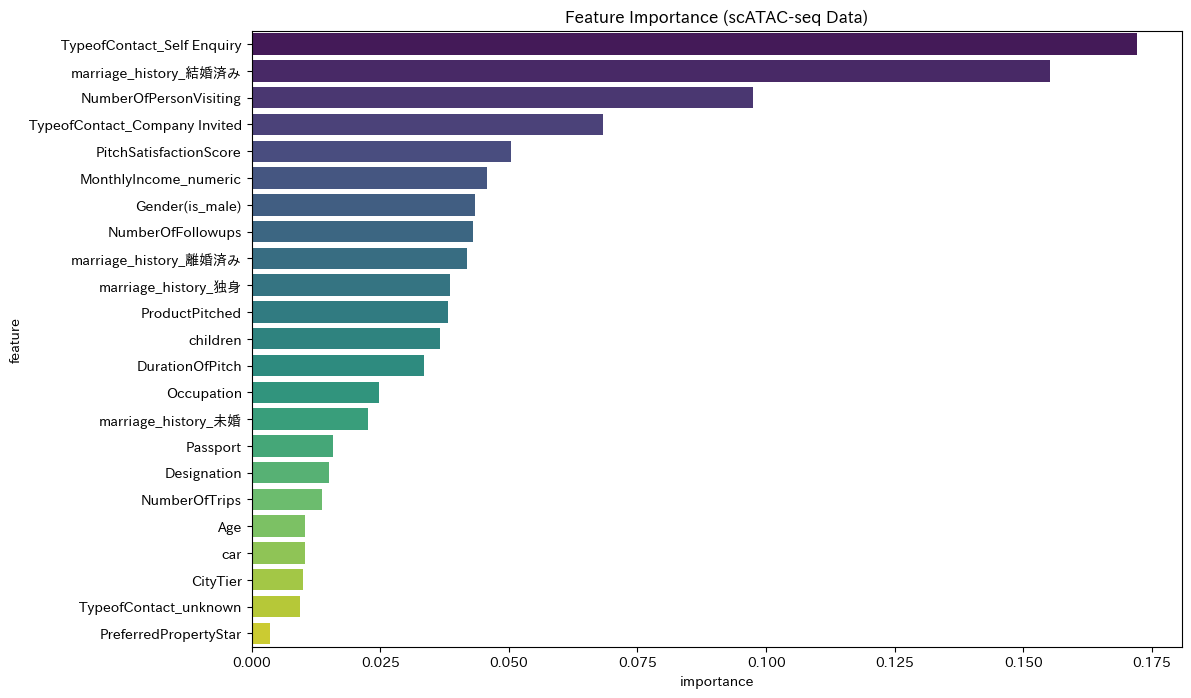

In [57]:
feature_importances.sort_values(
    by = "importance", 
    ascending = False, 
    inplace = True
)
plt.figure(figsize = (12, 8))
sns.barplot(y = feature_importances["feature"][:25], x = feature_importances["importance"][:25], palette = "viridis")
plt.title("Feature Importance (scATAC-seq Data)")
plt.savefig(data_directory_name + "/feat_imp_tb_atac.png", dpi = 100)
plt.show()

In [59]:
val_predicted_df = pd.DataFrame()
val_predicted_df["acutual"] = y_val
val_predicted_df["prediction"] = tabnet_model.predict_proba(X_val)[:, 1]

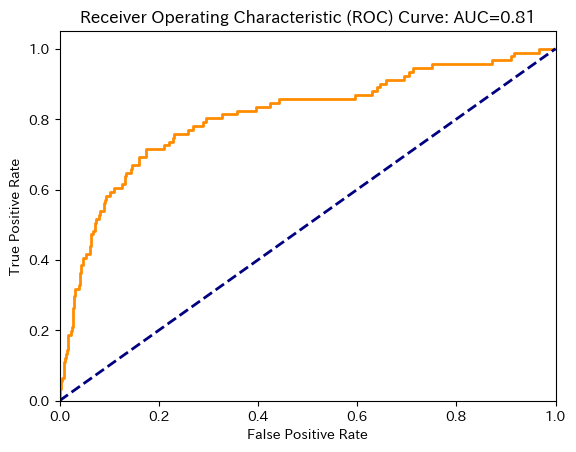

In [65]:
# 実際のラベルと予測確率を取得
y_true = val_predicted_df["acutual"]
y_pred = val_predicted_df["prediction"]

# ROC曲線を計算
fpr, tpr, thresholds = roc_curve(y_true, y_pred)

# AUCを計算
roc_auc = auc(fpr, tpr)

# ROC曲線をプロット
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve: AUC={0:0.2f}'.format(roc_auc))
plt.savefig(data_directory_name + "/val_roc_curve.png", dpi = 100)


In [47]:
# 特徴量として使用するカラムを定義 (NUMERIC_COLUMNSに基づく)
X_test = test_df.drop(columns=["id"]).values  # "id" カラムを除外して特徴量に
y_test = tabnet_model.predict_proba(X_test)[:, 1]  # 予測確率を取得

# 結果をデータフレームに変換
submission_df = pd.DataFrame({
    "id": test_df["id"].astype(int),  # "id" カラムを使用
    "prediction": y_test
})

# CSVファイルに保存
submission_df.to_csv(data_directory_name + "/submission.csv", index=False, header=None)